In [1]:
import os
import numpy as np
import torch
from PIL import Image
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import functools
import operator
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [2]:
class HPADataset(object):
    def __init__(self, root, transforms=None):
        self.img_dir = os.path.join(root, 'train')
        self.mask_dir = os.path.join(root, 'hpa_cell_mask')
        self.transforms = transforms
        
        self.df = pd.read_csv(root+'/train.csv')
        
        #dropping this image since it has no masks
        self.df.drop(self.df[self.df['ID']=='940f418a-bba4-11e8-b2b9-ac1f6b6435d0'].index, inplace = True)  
        
        #Split labels
        self.df["Label"] = self.df["Label"].str.split("|")
        
        #fetch only images that have one label
        self.df["Label Count"] = self.df['Label'].str.len()
        self.df = self.df[self.df['Label Count'] == 1]
        self.imgs = list(self.df['ID'])  
        
        #image class
        self.classes = functools.reduce(operator.iconcat, self.df['Label'].values, [])

    
    def __getitem__(self, idx):
        
        # load images and masks
        img = self.load_RGBY_image(self.img_dir, self.imgs[idx])
        img = Image.fromarray(np.uint8(img)).convert('RGB')
        
        masks, obj_ids = self.load_mask(self.imgs[idx])
     
        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
       
        boxes = []
        labels = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(int(self.classes[idx]))
       
        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        if len(boxes) == 0:
            print(self.imgs[idx], boxes.shape)
  
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
       
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)
    
    def read_img(self, path, image_id, color, image_size=None):
        filename = f'{path}/{image_id}_{color}.png'
        assert os.path.exists(filename), f'not found {filename}'
        img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
        if image_size is not None:
            img = cv2.resize(img, (image_size, image_size))
        if img.max() > 255:
            img_max = img.max()
            img = (img/255).astype('uint8')
        return img

    # image loader, using rgb only here
    def load_RGBY_image(self, path, image_id, image_size=None):
        red = self.read_img(path, image_id, "red", image_size)
        green = self.read_img(path, image_id, "green", image_size)
        blue = self.read_img(path, image_id, "blue", image_size)

        stacked_images = np.transpose(np.array([red, green, blue]), (1,2,0))
        return stacked_images
    
    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # Read mask files from 
        masks = []
        class_ids = []
        cell_mask = np.load(f'{self.mask_dir}/{image_id}.npz')['arr_0']

        #find number of cells in the image
        mask_ids = np.unique(cell_mask)
        
        #Remove background
        mask_ids = mask_ids[1:]
        
        #create binary mask for every cell in the image
        masks = cell_mask == mask_ids[:,None, None]

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID, we return an array of ones
        return masks, mask_ids

In [3]:
cell_mask_dir = './hpa_cell_mask'    
ROOT = './data/'
train_or_test = 'train'
def read_img(image_id, color, train_or_test='train', image_size=None):
    filename = f'{ROOT}/{train_or_test}/{image_id}_{color}.png'
    assert os.path.exists(filename), f'not found {filename}'
    img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
    if image_size is not None:
        img = cv2.resize(img, (image_size, image_size))
    if img.max() > 255:
        img_max = img.max()
        img = (img/255).astype('uint8')
    return img

# image loader, using rgb only here
def load_RGBY_image(image_id, train_or_test='train', image_size=None):
    red = read_img(image_id, "red", train_or_test, image_size)
    green = read_img(image_id, "green", train_or_test, image_size)
    blue = read_img(image_id, "blue", train_or_test, image_size)
    #yellow = read_img(image_id, "yellow", train_or_test, image_size)
    stacked_images = np.transpose(np.array([red, green, blue]), (1,2,0))
    return stacked_images

# print utility from public notebook
def print_masked_img(image_id, mask):
    img = load_RGBY_image(image_id, train_or_test)
    
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask)
    plt.title('Mask')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(img)
    plt.imshow(mask, alpha=0.6)
    plt.title('Image + Mask')
    plt.axis('off')
    plt.show()
    
def load_mask(image_id):
    """Generate instance masks for an image.
    Returns:
    masks: A bool array of shape [height, width, instance count] with
        one mask per instance.
    class_ids: a 1D array of class IDs of the instance masks.
    """
    # Read mask files from .png image
    mask_dir = ROOT+'hpa_cell_mask'
    masks = []
    class_ids = []
    cell_mask = np.load(f'{mask_dir}/{image_id}.npz')['arr_0']
    
    mask_ids = np.unique(cell_mask)
    
    mask_ids = mask_ids[1:]
    masks = cell_mask == mask_ids[:,None, None]

    # Return mask, and array of class IDs of each instance. Since we have
    # one class ID, we return an array of ones
    return masks, mask_ids

In [4]:
dataset = HPADataset('./data')
img, target = dataset[0]

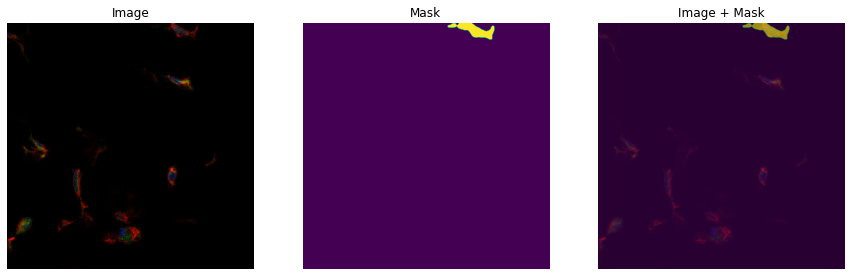

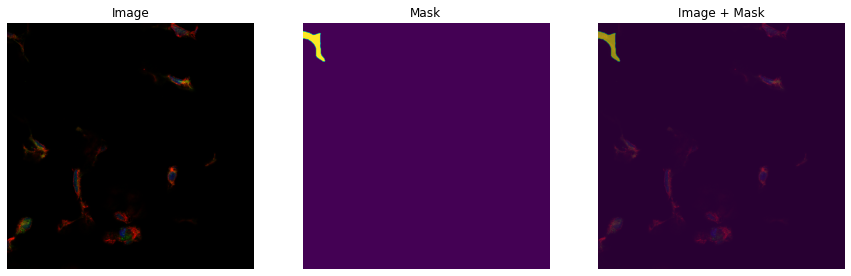

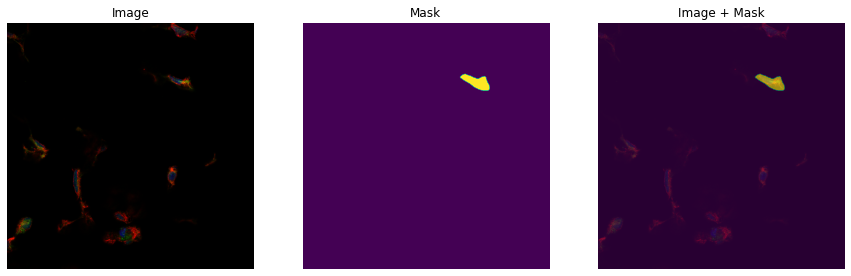

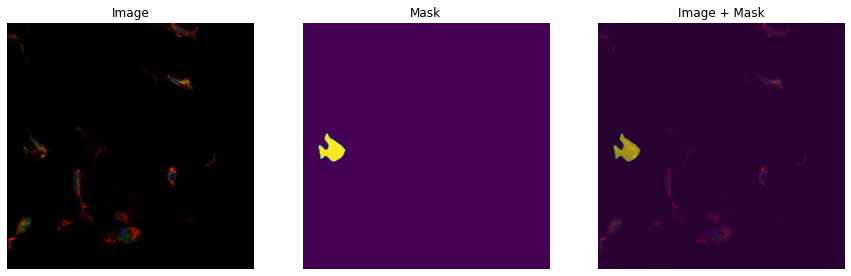

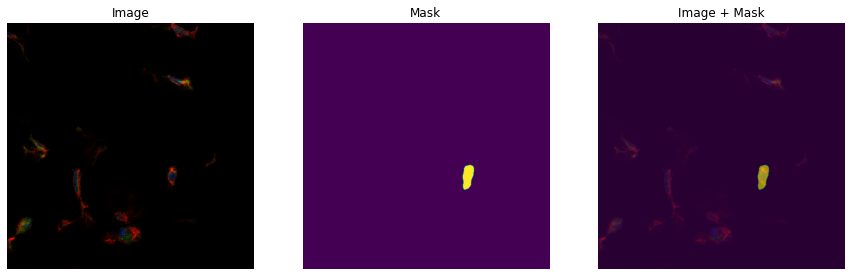

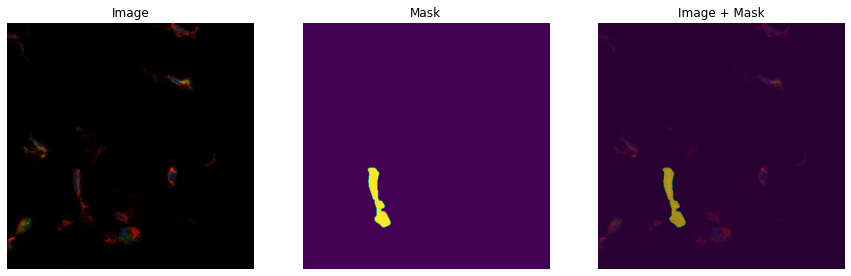

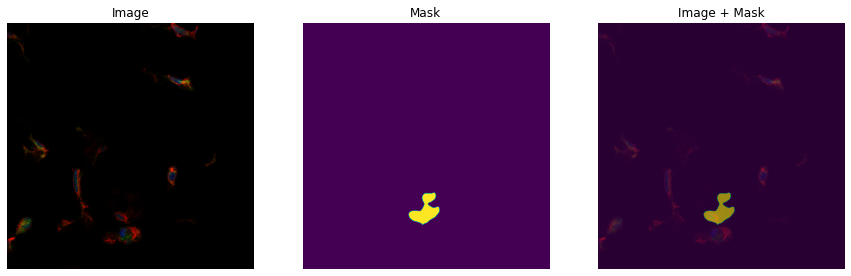

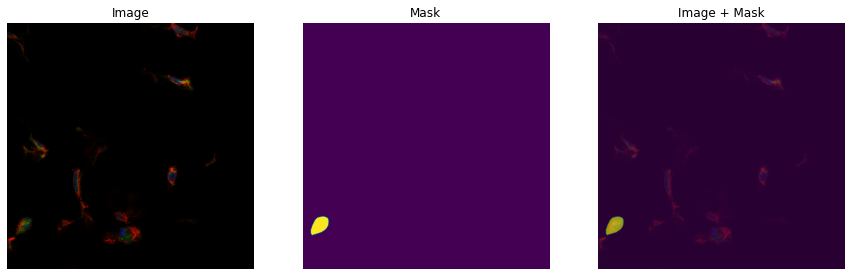

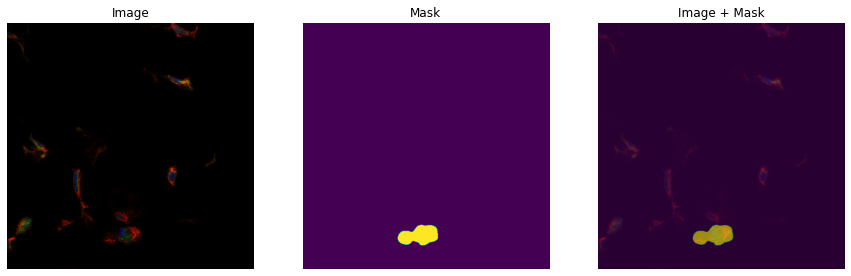

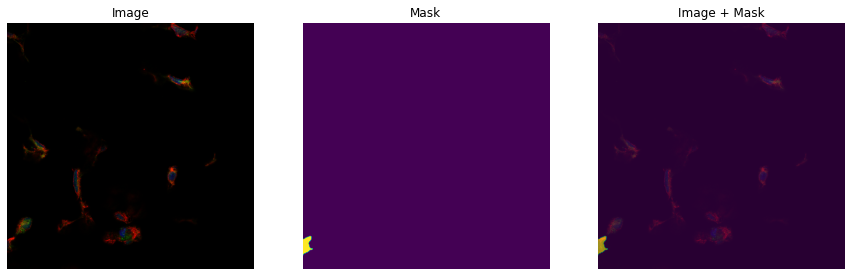

In [5]:
img_id = dataset.imgs[0]
for mask in target['masks']:
    print_masked_img(img_id, mask)

In [ ]:
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [ ]:
from utils.engine import train_one_epoch, evaluate
import utils.utils
import utils.transforms as T

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
# use our dataset and defined transformations
ROOT = './data'
dataset = HPADataset(ROOT, transforms=get_transform(train=True))
dataset_val = HPADataset(ROOT, transforms=get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_val = torch.utils.data.Subset(dataset_val, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=True, num_workers=8,
    collate_fn=utils.utils.collate_fn)

data_loader_val = torch.utils.data.DataLoader(
    dataset_val, batch_size=8, shuffle=False, num_workers=8,
    collate_fn=utils.utils.collate_fn)


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 20

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
device
# print(model)

In [ ]:
# let's train it for 10 epochs
num_epochs = 10
checkpoint_dir ='./checkpoints'
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)
    torch.save(model.state_dict(), os.path.join(checkpoint_dir, 'epoch-{}.pth'.format(epoch)))